## Analyze the Spatial Autocorrelation of 2016 Presidential Election Data 
##  ----------at County Level----------
The aim of my project5 is to **analyze the spatial autocorrelation, clusters and outliers** of 2016 Presidential Election Data, **using the Global and Local Moran's I coefficient.**

The county election data used in this project is under an open license, and can be download in https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ

**The main steps are:**<br>
**(1)** Connect to the PostgreSQL database, read the shapefile data and the csv file. <br>
**(2)** Pre-possess election data(.cvs file). <br>
**(3)** Merge the non spatial data with the spatial data. <br>
**(4)** Choose K-Nearest Neighbor(KNN) as the spatial weight matrix.<br>
**(5)** Conduct Spatial Autocorrelation ( Global Moran's I ) analysis.<br>
**(6)** Conduct Clusters and Outliers  ( Local Moran's I ) analysis.<br>
**(7)** Plot the outcome data and maps.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot
import mapclassify
import libpysal
import psycopg2
import json

* Connect to the database in **PostgreSQL**.

try:
    connection = psycopg2.connect(user = "postgres",
                                  password = "12345688",
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "ssci586")

    cursor = connection.cursor()
    # Print PostgreSQL Connection properties
    print ( connection.get_dsn_parameters(),"\n")

    # Print PostgreSQL version
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record,"\n")

except (Exception, psycopg2.Error) as error :
    print ("Error while connecting to PostgreSQL", error)

* closing database connection connectcursor.close()

connection.close()
print("PostgreSQL connection is closed")

In [2]:
table_csv_path = "F:/us_county_data/countypres2016.csv"
data_df=pd.read_csv(table_csv_path, dtype = {'FIPS': str})

In [3]:
# Use the notnull function and the loc function to create a new dataframe without null FIPS records
data_df = data_df.loc[data_df['FIPS'].notnull()]

In [4]:
# Check how many records have a FIPS value with four characters
trunc_df = data_df.loc[data_df['FIPS'].str.len() == 4]

In [5]:
# Define a helper function to fix truncated zeros, with one parameter: the value to be processed
def fix_trunc_zeros(val):
    # Use an if statement to check if there are four characters in the string representation of the value
    if len(str(val)) == 4:
        # If this is the case, return the value with an appended "0" in the front
        return "0"+str(val)
    # Otherwise...
    else:
        # Return the value itself
        return str(val)

In [6]:
# Run helper function on the FIPS field using the apply and lambda method 
data_df['FIPS'] = data_df['FIPS'].apply(lambda x: fix_trunc_zeros(x))

In [7]:
# Set an index using mulitple fields, which "locks" these fields before the table pivots
# Use the built-in groupby function for the FIPS and year fields, which you use to group the data by candidate
# Use unstack to perform the table pivot, which will rotate the table and turn rows into columns
df_out = data_df.set_index(['FIPS', 
                            'year', 
                            'county', 
                            'state', 
                            'state_po', 
                            'office', 
                            data_df.groupby(['FIPS', 'year']).cumcount()+1]).unstack()

# Use the indexes for the columns to set column names (Ex: candidate_1, candidate_2, votes_1, votes_2, etc.)
df_out.columns = df_out.columns.map('{0[0]}_{0[1]}'.format)

# Rename columns 
df_out = df_out.rename(columns={"candidate_1": "candidate_dem",
                                "candidatevotes_1": "votes_dem",
                                "candidate_2": "candidate_gop",
                                "candidatevotes_2": "votes_gop",
                                "totalvotes_1": "votes_total",
                                "state_po": "state_abbrev"
                                })

# Keep only the necessary columns
df_out = df_out[["candidate_dem", "votes_dem",
                 "candidate_gop", "votes_gop",
                 "votes_total"]]

# Remove the multiindex since we no longer need these fields to be "locked" for the pivot
df_out.reset_index(inplace=True)

In [8]:
df_out.loc[df_out['FIPS'] == '46113', 'FIPS'] = "46102"
df_out.loc[df_out['FIPS'] == '46102']

,FIPS,year,county,state,state_po,office,candidate_dem,votes_dem,candidate_gop,votes_gop,votes_total
2428,46102,2016,Oglala Lakota,South Dakota,SD,President,Hillary Clinton,2510.0,Donald Trump,241.0,2905


In [9]:
# Calculate voter share attributes
df_out['democratic'] = df_out['votes_dem'] / df_out['votes_total']
df_out['republican'] = df_out['votes_gop'] / df_out['votes_total']

df_out.head()

,FIPS,year,county,state,state_po,office,candidate_dem,votes_dem,candidate_gop,votes_gop,votes_total,democratic,republican
0,01001,2016,Autauga,Alabama,AL,President,Hillary Clinton,5936.0,Donald Trump,18172.0,24973,0.237697,0.727666
1,01003,2016,Baldwin,Alabama,AL,President,Hillary Clinton,18458.0,Donald Trump,72883.0,95215,0.193856,0.765457
2,01005,2016,Barbour,Alabama,AL,President,Hillary Clinton,4871.0,Donald Trump,5454.0,10469,0.465278,0.520967
3,01007,2016,Bibb,Alabama,AL,President,Hillary Clinton,1874.0,Donald Trump,6738.0,8819,0.212496,0.764032
4,01009,2016,Blount,Alabama,AL,President,Hillary Clinton,2156.0,Donald Trump,22859.0,25588,0.084258,0.893348


In [10]:
shp = gpd.read_file("F:/us_county_data/us_county.shp")

In [11]:
join = shp.merge(df_out, on='FIPS')

In [12]:
join_f = gpd.GeoDataFrame(join, crs="EPSG:4326")

In [13]:
join_f = join_f [["FIPS", "state_x", "county_x", "democratic", "republican", "geometry"]]

### Use KNN spatial matrix to conduct analysis
* Create a spatial weight matrix based on the spatial structure of the input shapefile, U.S. states boundary.<br>

In this project, **KNN** method is selected as the spatial weight matrix, because there are 2 islands(disconnected components), Hawaii and Alaska, in the dataset. KNN is a common spatial weight matrix constructed based on k nearest neighbors. In this case, K is set as 5. <br>
 
A large part of the analysis result depends on the spatial weight matrix. Therefore, I would also use Queen spatial matrix to make a comparison, see if the results are different.

In [14]:
w = libpysal.weights.KNN.from_dataframe(join_f,k=5)

* Conduct spatial autocorrelation analysis, and caculate the **Global Moran's I coefficient** based on the Democratic % and Republican % of the presidential vote by states. The Global Moran focuses on the overall spatial structure.

**Moran'I coefficients** can be used to indicate whether the spatial pattern of the state election data expressed is **clustered, dispersed, or random**. 

(1) If the coefficient **> 0**, it means that there is positive spatial autocorrelation; 

(2) If the coefficient **< 0**, there is positive spatial autocorrelation; If the coefficient < 0, there is negative spatial autocorrelation; 

(3) If the coefficient is **near 0**, the features with the attribute data distribute randomly.

In this case, both the Global Morans are > 0, which means there is **positive spatial autocorrelation**.

In [15]:
from esda.moran import Moran

y_d = join_f['democratic'].values
moran_d = Moran(y_d, w)
moran_d.I

y_r = join_f['republican'].values
moran_r = Moran(y_r, w)
print(f'Global Moran\'s I: \n   Republican----{moran_r.I}, \n   Democratic----{moran_d.I}')

Global Moran's I: 
   Republican----0.6291524663819902, 
   Democratic----0.6251752507555921


* Use **p-value** to evaluate the Index

Moran's I is unlike most other correlation coefficients in that you can’t take the index at face value. It is an inferential statistic, and you have to determine statistical significance before you can read the result. This is done with a simple hypothesis test, calculating a z-score and its associated p-value.

In this case, both the coefficients are **reliable (p < 0.05)**.

In [16]:
print(moran_d.p_sim, moran_r.p_sim)

0.001 0.001


* Conduct the clusters and outliers analysis identifies spatial clusters and outliers of features with high or low values, using the **Local Moran's I coefficient**. The Llobal Moran focuses on the indibiduals.

**The Moran scatterplot** is used for visual exploration of spatial autocorrelation.

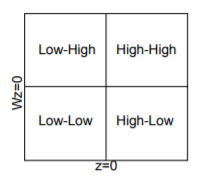

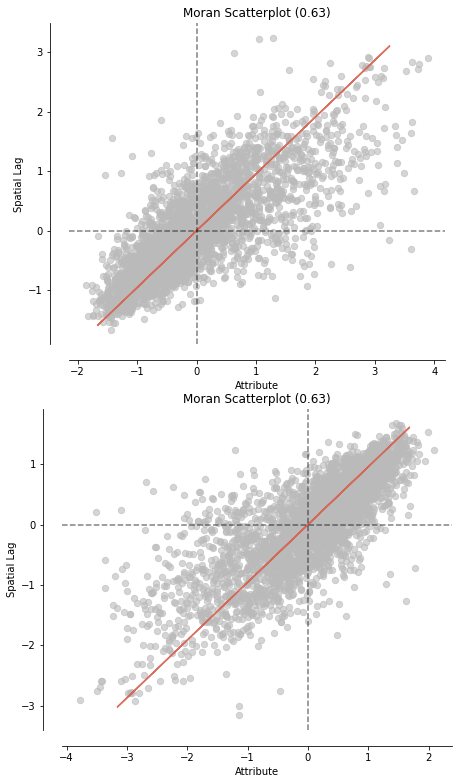

In [26]:
from splot.esda import moran_scatterplot

fig, axs = plt.subplots(2, figsize=(8,13),
                        subplot_kw={'aspect': 'equal'})

# Democratic % of the Presidential Vote by States, 2016
moran_scatterplot(moran_d, ax=axs[0])
# Republican % of the Presidential Vote by States, 2016
moran_scatterplot(moran_r, ax=axs[1])

plt.show()

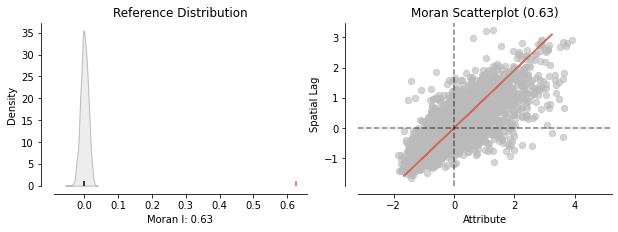

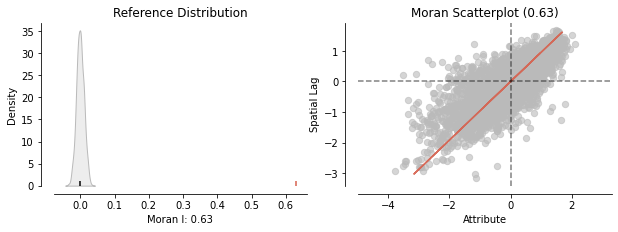

In [18]:
from splot.esda import plot_moran

plot_moran(moran_d, zstandard=True, figsize=(10,3))
plot_moran(moran_r, zstandard=True, figsize=(10,3))

plt.show()

* Plot two maps based on the original data.

(1) Republican % of the Presidential Vote by States, 2016

(2) Democratic % of the Presidential Vote by States, 2016

<span style="color:orange">***After researching online, the deprecated code of the warning seems to come from the original source code of the latest Scripy package*.</span>

D:\Anaconda3\envs\gis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


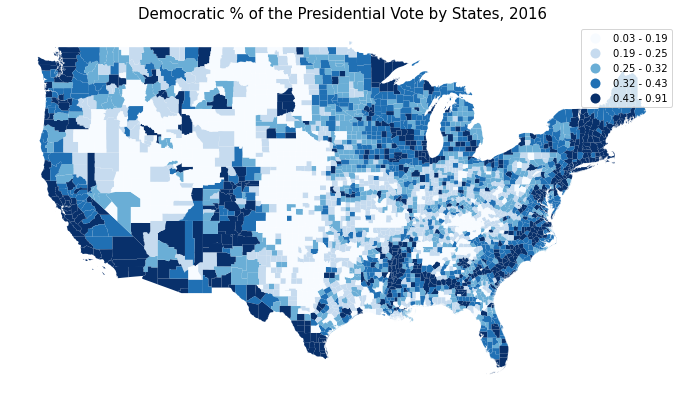

In [19]:
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'aspect':'equal'})
join_f.plot(column='democratic',legend=True, ax=ax, cmap='Blues', scheme='quantiles')
#ax.set_xlim(-130,-65)
#ax.set_ylim(20,55)
ax.set_title("Democratic % of the Presidential Vote by States, 2016", fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_axis_off()

D:\Anaconda3\envs\gis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


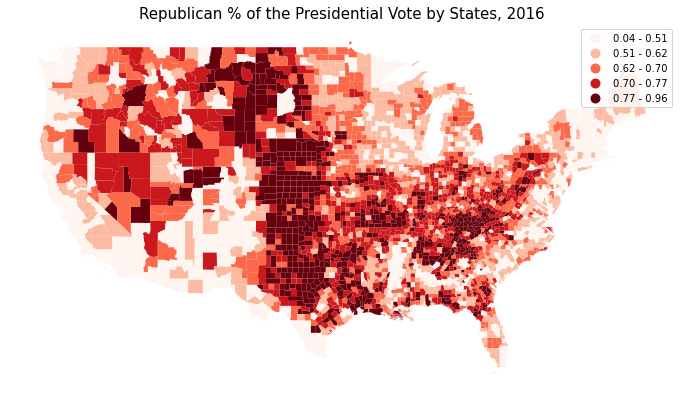

In [20]:
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'aspect':'equal'})
join_f.plot(column='republican',legend=True, ax=ax, cmap='Reds', scheme='quantiles')
#ax.set_xlim(-130,-65)
#ax.set_ylim(20,55)
ax.set_title("Republican % of the Presidential Vote by States, 2016", fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_axis_off()

* Given a threshold of the **p-value = 0.05**, select the results with **statistic significance** for Local Autocorrelation analysis. 
* **Points are colored by significance**.

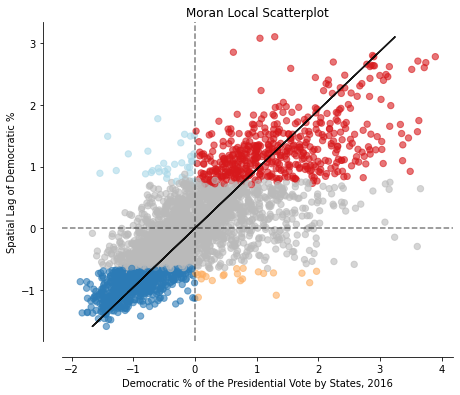

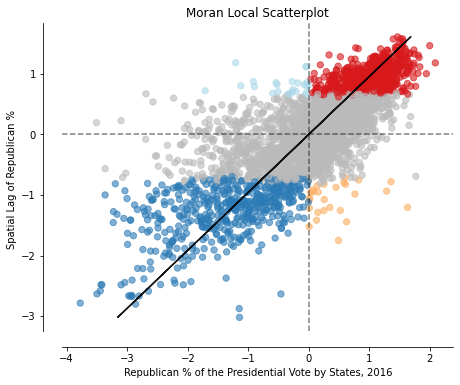

In [21]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
moran_loc_d = Moran_Local(y_d, w)
fig, ax = moran_scatterplot(moran_loc_d, p=0.05)
ax.set_xlabel('Democratic % of the Presidential Vote by States, 2016')
ax.set_ylabel('Spatial Lag of Democratic %')

moran_loc_r = Moran_Local(y_r, w)
fig1, ax1 = moran_scatterplot(moran_loc_r, p=0.05)
ax1.set_xlabel('Republican % of the Presidential Vote by States, 2016')
ax1.set_ylabel('Spatial Lag of Republican % ')

plt.show()

* Plot two maps based on the **Local Moran Scatterplot**.

(1) Geographic Clustering Based on Democratic % Presidential Vote by States, 2016

(2) Geographic Clustering Based on Republican % Presidential Vote by States, 2016

**The Lengend of the Result Map:**

* **HH & LL** - Statistically significant clusters of high values (HH), clusters of low values (LL).
* **HL & LH** - Outliers in which a high value is surrounded primarily by low values (HL), and outliers in which a low value is surrounded primarily by high values (LH).
* **ns** - Not Statistically significant.

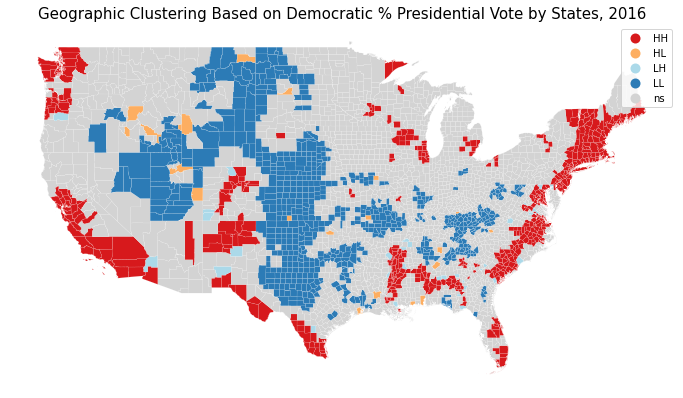

In [22]:
from splot.esda import lisa_cluster

fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
ax.set_title("Geographic Clustering Based on Democratic % Presidential Vote by States, 2016", fontdict={'fontsize': '15', 'fontweight' : '3'})
lisa_cluster(moran_loc_d, join_f, p=0.05, ax=ax)

plt.show()

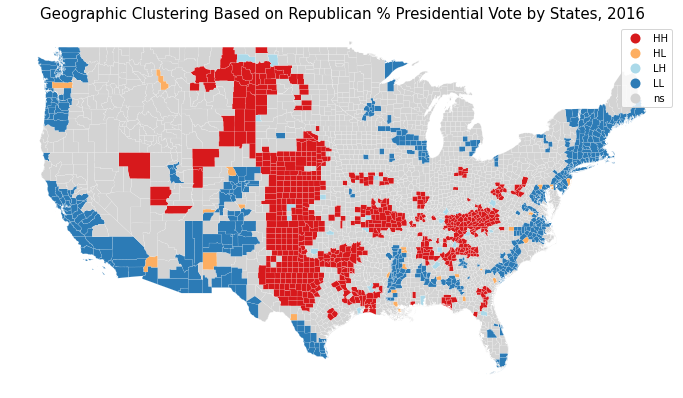

In [23]:
fig1, ax1 = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
ax1.set_title("Geographic Clustering Based on Republican % Presidential Vote by States, 2016", fontdict={'fontsize': '15', 'fontweight' : '3'})
lisa_cluster(moran_loc_r, join_f, p=0.05, ax=ax1)

plt.show()